In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Data Preprocessing<a class="anchor" id="1"></a><a class="anchor" id="1"></a>

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import string
import re
from unicodedata import normalize
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import LSTM,Dense,Embedding,RepeatVector,TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import corpus_bleu
import pandas as pd
from string import punctuation
import matplotlib.pyplot as plt
from IPython.display import Markdown, display

def printmd(string):
    # Print with Markdowns
    display(Markdown(string))

In [ ]:
total_sentences = 2500

# Load the dataset
dataset = pd.read_csv("/content/drive/MyDrive/databaru/50transkrip.csv", nrows = total_sentences)
dataset = dataset.drop(columns=['filename'])

# What proportion of the sentences will be used for the test set
test_proportion = 0.1
train_test_threshold = int( (1-test_proportion) * total_sentences)

printmd(f'{total_sentences} kalimat akan diolah (teks aktual beserta terjemahannya)')
printmd(f'{train_test_threshold} kalimat akan digunakan untuk melatih model')
printmd(f'{total_sentences-train_test_threshold} kalimat akan digunakan untuk pengujian model')

2500 kalimat akan diolah (teks aktual beserta terjemahannya)

2250 kalimat akan digunakan untuk melatih model

250 kalimat akan digunakan untuk pengujian model

In [ ]:
# Shuffle the dataset
dataset = dataset.sample(frac=1, random_state=0)
dataset.iloc[1000:1010]

,bugis,indo
724,aleng ka baki akki dapo'e,ambilkan saya baki di dapur
1964,pake bawang ni potolo' ku,pakai saja pensilku
19,makenni maneng mopa manu'ku,semua ayam saya masih kecil
2160,makkukue maega ni pake bedda lotong,sekarang banyak yang menggunakan bedak hitam
468,engka siaga bola na?,ada berapa rumahnya?
2134,aja muallupai mandre wenni,jangan lupa makan malam
54,winda iya' aseng ku,Nama saya Winda
189,egana tu agagang mu ta'tale,banyaknya barangmu yang berserakan
505,tennapodo de'to nakenna ki abala,semoga kita tidak terkena celaka
1317,ebbureng ka wae pella,tolong buatkan air panas


In [ ]:
def clean(string):
    # Clean the string
    # Ensure the input is a string before applying string methods
    string = str(string)
    string = string.replace("\u202f"," ") # Replace no-break space with space
    string = string.lower()

    # Delete the punctuation and the numbers
    for p in punctuation + "«»" + "012345670123456789":
        string = string.replace(p," ")

    string = re.sub('\s+',' ', string)
    string = string.strip()

    return string

# Clean the sentences
# Convert columns to string type, filling potential NaN values with empty strings
dataset["bugis"] = dataset["bugis"].astype(str).apply(lambda x: clean(x))
dataset["indo"] = dataset["indo"].astype(str).apply(lambda x: clean(x))

# Select one part of the dataset
dataset = dataset.values
dataset = dataset[:total_sentences]

# split into train/test
train, test = dataset[:train_test_threshold], dataset[train_test_threshold:]

# Define the name of the source and of the target
# This will be used in the outputs of this notebook
source_str, target_str = "Bugis", "Indonesia"

# The index in the numpy array of the source and of the target
idx_src, idx_tar = 0, 1

In [ ]:
# Display the result after cleaning
pd.DataFrame(dataset[1000:1010])

,0,1
0,aleng ka baki akki dapo e,ambilkan saya baki di dapur
1,pake bawang ni potolo ku,pakai saja pensilku
2,makenni maneng mopa manu ku,semua ayam saya masih kecil
3,makkukue maega ni pake bedda lotong,sekarang banyak yang menggunakan bedak hitam
4,engka siaga bola na,ada berapa rumahnya
5,aja muallupai mandre wenni,jangan lupa makan malam
6,winda iya aseng ku,nama saya winda
7,egana tu agagang mu ta tale,banyaknya barangmu yang berserakan
8,tennapodo de to nakenna ki abala,semoga kita tidak terkena celaka
9,ebbureng ka wae pella,tolong buatkan air panas


In [ ]:
def create_tokenizer(lines):
    # fit a tokenizer
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

def max_len(lines):
    # max sentence length
    return max(len(line.split()) for line in lines)

def encode_sequences(tokenizer, length, lines):
    # encode and pad sequences
    X = tokenizer.texts_to_sequences(lines) # integer encode sequences
    X = pad_sequences(X, maxlen=length, padding='post') # pad sequences with 0 values
    return X

def encode_output(sequences, vocab_size):
    # one hot encode target sequence
    ylist = list()
    for sequence in sequences:
        encoded = to_categorical(sequence, num_classes=vocab_size)
        ylist.append(encoded)
    y = np.array(ylist)
    y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
    return y

# Prepare target tokenizer
tar_tokenizer = create_tokenizer(dataset[:, idx_tar])
tar_vocab_size = len(tar_tokenizer.word_index) + 1
tar_length = max_len(dataset[:, idx_tar])
printmd(f'\nTarget ({target_str}) Vocabulary Size: {tar_vocab_size}')
printmd(f'Target ({target_str}) Max Length: {tar_length}')

# Prepare source tokenizer
src_tokenizer = create_tokenizer(dataset[:, idx_src])
src_vocab_size = len(src_tokenizer.word_index) + 1
src_length = max_len(dataset[:, idx_src])
printmd(f'\nSumber ({source_str}) Vocabulary Size: {src_vocab_size}')
printmd(f'Sumber ({source_str}) Max Length: {src_length}\n')

# Prepare training data
trainX = encode_sequences(src_tokenizer, src_length, train[:, idx_src])
trainY = encode_sequences(tar_tokenizer, tar_length, train[:, idx_tar])
trainY = encode_output(trainY, tar_vocab_size)

# Prepare test data
testX = encode_sequences(src_tokenizer, src_length, test[:, idx_src])
testY = encode_sequences(tar_tokenizer, tar_length, test[:, idx_tar])
testY = encode_output(testY, tar_vocab_size)


Target (Indonesia) Vocabulary Size: 158

Target (Indonesia) Max Length: 7


Sumber (Bugis) Vocabulary Size: 153

Sumber (Bugis) Max Length: 7


# 2. Create and train the model<a class="anchor" id="2"></a>

In [ ]:
def create_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
    # Create the model
    model = Sequential()
    model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
    model.add(LSTM(n_units))
    model.add(RepeatVector(tar_timesteps))
    model.add(LSTM(n_units, return_sequences=True))
    model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
    return model

# Create model
model = create_model(src_vocab_size, tar_vocab_size, src_length, tar_length, 256)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(trainX, trainY, epochs=500, batch_size=32, validation_split=0.1, verbose=1,
          callbacks=[EarlyStopping(
                        monitor='val_accuracy',
                        patience=5,
                        restore_best_weights=True
                    )
            ])

Epoch 1/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 15s 139ms/step - accuracy: 0.3403 - loss: 4.0467 - val_accuracy: 0.3829 - val_loss: 3.0804
Epoch 2/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.3935 - loss: 3.0360 - val_accuracy: 0.4540 - val_loss: 2.2443
Epoch 3/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - accuracy: 0.5340 - loss: 1.8631 - val_accuracy: 0.8978 - val_loss: 0.6552
Epoch 4/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - accuracy: 0.9260 - loss: 0.5150 - val_accuracy: 0.9613 - val_loss: 0.2493
Epoch 5/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - accuracy: 0.9819 - loss: 0.1950 - val_accuracy: 1.0000 - val_loss: 0.0854
Epoch 6/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.9984 - loss: 0.0804 - val_accuracy: 0.9943 - val_loss: 0.0622
Epoch 7/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9982 - loss: 0.0549 - val_accuracy: 1.0000 - val_loss: 0.0325
Epoch 8/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - accuracy: 1.0000 - loss: 0.0315 - val_accurac

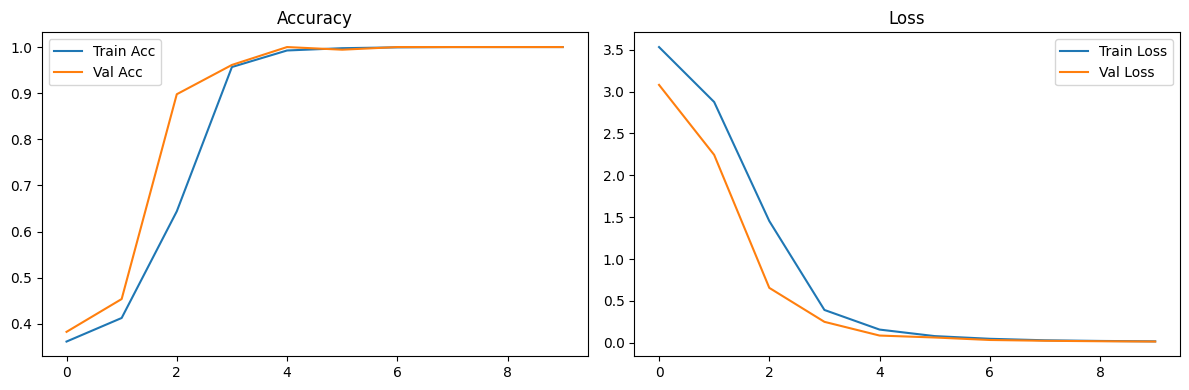

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 7, 256)         │        39,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 256)            │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 7, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 7, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 7, 158)         │        40,606 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,391,196 (12.94 MB)

 Trainable params: 1,130,398 (4.31 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,260,798 (8.62 MB)

# 3. Result on the test set<a class="anchor" id="3"></a>

In [ ]:
from tabulate import tabulate
import numpy as np

def word_for_id(integer, tokenizer):
    # Map an integer to a word
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def predict_seq(model, tokenizer, source):
    # Generate translation from a source sequence
    prediction = model.predict(source, verbose=0)[0]
    integers = [np.argmax(vector) for vector in prediction]
    target = []

    for integer in integers:
        word = word_for_id(integer, tokenizer)
        if word is None:
            break
        target.append(word)

    return ' '.join(target)

def compare_prediction(model, tokenizer, sources, raw_dataset, limit=20):
    # Evaluate a model
    results = []

    for i, source in enumerate(sources):
        if i >= limit:
            break
        # Ensure source is reshaped to 2D array for prediction
        source_reshaped = np.reshape(source, (1, -1))  # Reshaping to a 2D array (1, n)

        translation = predict_seq(model, tokenizer, source_reshaped)

        # Prepare the results
        raw_src = raw_dataset[i][idx_src] # Access source sentence using index
        raw_target = raw_dataset[i][idx_tar] # Access target sentence using index
        translated = translation

        results.append([raw_src[:50], raw_target[:50], translated[:50]])  # Display up to first 50 characters


    # Output results in a formatted table
    headers = ["Source Text (First 50 chars)", "Target Text (First 50 chars)", "Translated Text (First 50 chars)"]
    print(tabulate(results, headers=headers, tablefmt="pretty"))

# Test on some training sequences
print("### Result on the Training Set ###")
compare_prediction(model, tar_tokenizer, trainX, train)

# Test on some test sequences
print("\n\n### Result on the Test Set ###")
compare_prediction(model, tar_tokenizer, testX, test)

### Result on the Training Set ###
+----------------------------------------------------+----------------------------------------------------+----------------------------------------------------+
|            Source Text (First 50 chars)            |            Target Text (First 50 chars)            |          Translated Text (First 50 chars)          |
+----------------------------------------------------+----------------------------------------------------+----------------------------------------------------+
|                 winda iya aseng ku                 |                  nama saya winda                   |                  nama saya winda                   |
|              wedding ka ga melli otti              |           apakah saya boleh beli pisang            |           apakah saya boleh beli pisang            |
|            pettu sandala ku nasaba iko             |             sandalku putus karena kamu             |             sandalku putus karena kamu             |

# 4. Prediction evaluation with BLEU <a class="anchor" id="4"></a>

BLEU (bilingual evaluation understudy) is an algorithm for evaluating the quality of text which has been machine-translated from one natural language to another. Quality is considered to be the correspondence between a machine's output and that of a human: "the closer a machine translation is to a professional human translation, the better it is" – this is the central idea behind BLEU. BLEU was one of the first metrics to claim a high correlation with human judgements of quality, and remains one of the most popular automated and inexpensive metrics.

Scores are calculated for individual translated segments—generally sentences—by comparing them with a set of good quality reference translations. Those scores are then averaged over the whole corpus to reach an estimate of the translation's overall quality. Intelligibility or grammatical correctness are not taken into account.

BLEU's output is always a number between 0 and 1. This value indicates how similar the candidate text is to the reference texts, with values closer to 1 representing more similar texts. Few human translations will attain a score of 1, since this would indicate that the candidate is identical to one of the reference translations. For this reason, it is not necessary to attain a score of 1. Because there are more opportunities to match, adding additional reference translations will increase the BLEU score.


## Algorithm

BLEU uses a modified form of precision to compare a candidate translation against multiple reference translations. The metric modifies simple precision since machine translation systems have been known to generate more words than are in a reference text. This is illustrated in the following example from Papineni et al. (2002)

![example bleu](https://i.imgur.com/mrdpwun.png)

Of the seven words in the candidate translation, all of them appear in the reference translations. Thus the candidate text is given a unigram precision of P, where *m* is number of words from the candidate that are found in the reference, and *wt* is the total number of words in the candidate. This is a perfect score, despite the fact that the candidate translation above retains little of the content of either of the references.

The modification that BLEU makes is fairly straightforward. For each word in the candidate translation, the algorithm takes its maximum total count, *m_max*, in any of the reference translations. In the example above, the word "the" appears twice in reference 1, and once in reference 2. Thus *m_max* = 2.

For the candidate translation, the count *mw* of each word is clipped to a maximum of *m_max* for that word. In this case, "the" has *m_w* = 7 and *m_max*=2, thus *m_w* is clipped to 2. These clipped counts *m_w* are then summed over all distinct words in the candidate. This sum is then divided by the total number of unigrams in the candidate translation. In the above example, the modified unigram precision score would be: P = 1 / 7

In practice, however, using individual words as the unit of comparison is not optimal. Instead, BLEU computes the same modified precision metric using n-grams. The length which has the "highest correlation with monolingual human judgements" was found to be four. The unigram scores are found to account for the adequacy of the translation, how much information is retained. The longer n-gram scores account for the fluency of the translation, or to what extent it reads like "good English". ([source](https://en.wikipedia.org/wiki/BLEU))

![bleu score 2](https://i.imgur.com/tNYaD64.png)

In [ ]:
# It takes long to compute the BLEU Score

def bleu_score(model, tokenizer, sources, raw_dataset):
    # Get the bleu score of a model
    actual, predicted = [], []
    for i, source in enumerate(sources):
        # translate encoded source text
        source = source.reshape((1, source.shape[0]))
        translation = predict_seq(model, tar_tokenizer, source)
        raw_target, raw_src = raw_dataset[i]
        actual.append([raw_target.split()])
        predicted.append(translation.split())

    bleu_dic = {}
    bleu_dic['1-grams'] = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    bleu_dic['1-2-grams'] = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
    bleu_dic['1-3-grams'] = corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0))
    bleu_dic['1-4-grams'] = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))

    return bleu_dic

# Compute the BLEU Score
bleu_train = bleu_score(model, tar_tokenizer, trainX, train)
bleu_test = bleu_score(model, tar_tokenizer, testX, test)

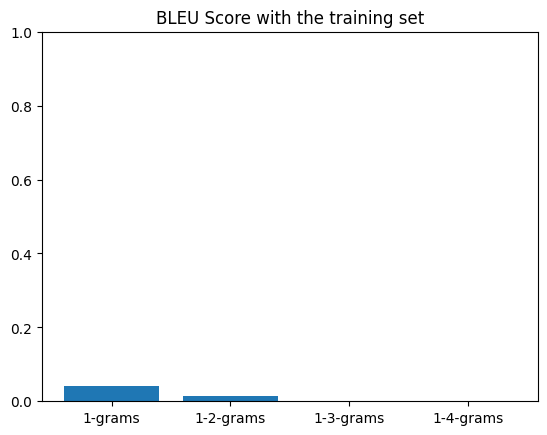

In [ ]:
plt.bar(x = bleu_train.keys(), height = bleu_train.values())
plt.title("BLEU Score with the training set")
plt.ylim((0,1))
plt.show()

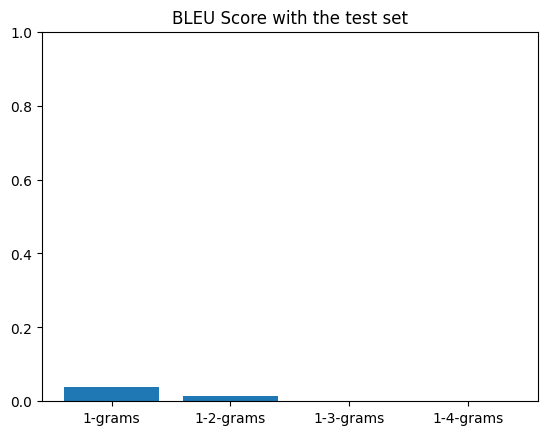

In [ ]:
plt.bar(x = bleu_test.keys(), height = bleu_test.values())
plt.title("BLEU Score with the test set")
plt.ylim((0,1))
plt.show()

In [ ]:
def bleu_score_no_ngram(model, tokenizer, sources, raw_dataset):
    # Get the bleu score of a model without n-grams
    actual, predicted = [], []
    for i, source in enumerate(sources):
        # translate encoded source text
        source = source.reshape((1, source.shape[0]))
        translation = predict_seq(model, tar_tokenizer, source)
        raw_target, raw_src = raw_dataset[i]
        actual.append([raw_target.split()])
        predicted.append(translation.split())

    # Calculate BLEU score with only 1-grams (no n-grams)
    bleu_1_gram = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))

    return bleu_1_gram

# Compute the BLEU Score without n-grams
bleu_train_no_ngram = bleu_score_no_ngram(model, tar_tokenizer, trainX, train)
bleu_test_no_ngram = bleu_score_no_ngram(model, tar_tokenizer, testX, test)

print(f"BLEU Score on Training Set (no n-grams): {bleu_train_no_ngram}")
print(f"BLEU Score on Test Set (no n-grams): {bleu_test_no_ngram}")

BLEU Score on Training Set (no n-grams): 0.041944637259949
BLEU Score on Test Set (no n-grams): 0.039571719125582286


In [ ]:
from tabulate import tabulate
import numpy as np
from nltk.translate.bleu_score import corpus_bleu


def word_for_id(integer, tokenizer):
    # Map an integer to a word
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def predict_seq(model, tokenizer, source):
    # Generate translation from a source sequence
    prediction = model.predict(source, verbose=0)[0]
    integers = [np.argmax(vector) for vector in prediction]
    target = []

    for integer in integers:
        word = word_for_id(integer, tokenizer)
        if word is None:
            break
        target.append(word)

    return ' '.join(target)

def calculate_sentence_bleu(reference, hypothesis):
    # Calculate BLEU score for a single sentence pair
    # corpus_bleu expects a list of references for each hypothesis
    # For a single sentence, the reference is a list containing one list of words
    reference = [[reference.split()]]
    hypothesis = hypothesis.split()
    # Calculate 1-gram BLEU score for simplicity in the table
    # You can adjust weights for different n-grams if needed
    score = corpus_bleu(reference, [hypothesis], weights=(1.0, 0, 0, 0))
    return score * 100 # Return as percentage

# Create BLEU evaluation table
bleu_results = []
for i in range(len(test)):
    source_text = test[i][idx_src]
    target_text = test[i][idx_tar]

    # Encode and predict
    source_encoded = encode_sequences(src_tokenizer, src_length, [source_text])
    translated_text = predict_seq(model, tar_tokenizer, source_encoded)

    # Calculate sentence BLEU
    bleu_score_sentence = calculate_sentence_bleu(target_text, translated_text)

    bleu_results.append([i + 1, source_text[:50], translated_text[:50], target_text[:50], f"{bleu_score_sentence:.2f}"]) # Display up to first 50 characters

print("### Tabel Evaluasi BLEU ###")
headers_bleu = ["No", "Teks Aktual (Bugis)", "Hasil Terjemahan", "Teks Aktual (Indonesia)", "Skor BLEU (%)"]
print(tabulate(bleu_results, headers=headers_bleu, tablefmt="pretty"))

### Tabel Evaluasi BLEU ###
+-----+----------------------------------------------------+----------------------------------------------------+----------------------------------------------------+---------------+
| No  |                Teks Aktual (Bugis)                 |                  Hasil Terjemahan                  |              Teks Aktual (Indonesia)               | Skor BLEU (%) |
+-----+----------------------------------------------------+----------------------------------------------------+----------------------------------------------------+---------------+
|  1  |             ellingeng ka kaju na bale              |            belikan saya sayur dan ikan             |            belikan saya sayur dan ikan             |    100.00     |
|  2  |                aja mu tuli massasa                 |          jangan kalian selalu bertengkar           |          jangan kalian selalu bertengkar           |    100.00     |
|  3  |            pettu sandala ku nasaba iko           

In [ ]:
# Combine actual and predicted translations from training and test sets
combined_actual = []
combined_predicted = []

# Process training set
for i, source in enumerate(trainX):
    source_reshaped = source.reshape((1, source.shape[0]))
    translation = predict_seq(model, tar_tokenizer, source_reshaped)
    raw_target = train[i][idx_tar]
    combined_actual.append([raw_target.split()])
    combined_predicted.append(translation.split())

# Process test set
for i, source in enumerate(testX):
    source_reshaped = source.reshape((1, source.shape[0]))
    translation = predict_seq(model, tar_tokenizer, source_reshaped)
    raw_target = test[i][idx_tar]
    combined_actual.append([raw_target.split()])
    combined_predicted.append(translation.split())

# Calculate the combined corpus BLEU score (using standard weights 0.25 for all n-grams)
combined_bleu_score = corpus_bleu(combined_actual, combined_predicted, weights=(0.25, 0.25, 0.25, 0.25))

print(f"Combined Corpus BLEU Score (Train + Test): {combined_bleu_score}")

# You can also calculate with other weights if desired
# combined_bleu_1gram_only = corpus_bleu(combined_actual, combined_predicted, weights=(1.0, 0, 0, 0))
# print(f"Combined Corpus BLEU Score (Train + Test, 1-gram only): {combined_bleu_1gram_only}")

Combined Corpus BLEU Score (Train + Test): 0.958836958589684


# 5. Evaluation with WER (Word Error Rate)

Word Error Rate (WER) is a common metric for evaluating the performance of automatic speech recognition or machine translation systems. It measures the number of errors (insertions, deletions, and substitutions) needed to change the predicted sequence into the reference sequence, normalized by the length of the reference sequence. A lower WER indicates better performance.

The formula for WER is:

$ \text{WER} = \frac{S + D + I}{N} $

Where:
- $S$ is the number of substitutions
- $D$ is the number of deletions
- $I$ is the number of insertions
- $N$ is the number of words in the reference sequence

In [ ]:
!pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 36.4 MB/s eta 0:00:00


In [ ]:
import jiwer

def calculate_sentence_wer_details(reference, hypothesis):
    # Calculate WER details (S, D, I, N) for a single sentence pair
    measures = jiwer.process_words(reference, hypothesis)

    ref_words = reference.split()
    n = len(ref_words)

    # Handle empty reference
    if n == 0:
         return 0, 0, 0, 0, float('inf') if len(hypothesis.split()) > 0 else 0.0


    s = measures.substitutions
    d = measures.deletions
    i = measures.insertions
    wer_score = (s + d + i) / n

    return s, d, i, n, wer_score * 100 # Return as percentage

# Create WER evaluation table
wer_results = []
for i in range(len(test)):
    source_text = test[i][idx_src]
    target_text = test[i][idx_tar]

    # Encode and predict
    source_encoded = encode_sequences(src_tokenizer, src_length, [source_text])
    translated_text = predict_seq(model, tar_tokenizer, source_encoded)

    # Calculate sentence WER details
    s, d, i, n, wer_score_sentence = calculate_sentence_wer_details(target_text, translated_text)

    wer_results.append([target_text[:50], translated_text[:50], s, d, i, n, f"{wer_score_sentence:.2f}"]) # Display up to first 50 characters

print("\n### Tabel Evaluasi WER ###")
headers_wer = ["Terjemahan Sebenarnya", "Hasil Terjemahan", "S", "D", "I", "N", "WER (%)"]
print(tabulate(wer_results, headers=headers_wer, tablefmt="pretty"))


### Tabel Evaluasi WER ###
+----------------------------------------------------+----------------------------------------------------+---+---+---+---+---------+
|               Terjemahan Sebenarnya                |                  Hasil Terjemahan                  | S | D | I | N | WER (%) |
+----------------------------------------------------+----------------------------------------------------+---+---+---+---+---------+
|            belikan saya sayur dan ikan             |            belikan saya sayur dan ikan             | 0 | 0 | 0 | 5 |  0.00   |
|          jangan kalian selalu bertengkar           |          jangan kalian selalu bertengkar           | 0 | 0 | 0 | 4 |  0.00   |
|             sandalku putus karena kamu             |             sandalku putus karena kamu             | 0 | 0 | 0 | 4 |  0.00   |
|              jangan lupa makan malam               |              jangan lupa makan malam               | 0 | 0 | 0 | 4 |  0.00   |
|         saya ingin melihatnya me

In [ ]:
import jiwer

def wer(reference, hypothesis):
    # Calculate the Word Error Rate between a reference and a hypothesis
    # Use jiwer.process_words to get the error counts
    measures = jiwer.process_words(reference, hypothesis)

    # Calculate WER using the formula: (S + D + I) / N
    # N is the number of words in the reference
    ref_words = reference.split()
    n = len(ref_words)

    # Handle the case where the reference is empty to avoid division by zero
    if n == 0:
        # If hypothesis is also empty, WER is 0, otherwise infinity
        return 0.0 if len(hypothesis.split()) == 0 else float('inf')

    # Access the error counts from the WordOutput object
    s = measures.substitutions
    d = measures.deletions
    i = measures.insertions

    wer_score = (s + d + i) / n

    return wer_score

def calculate_average_wer(model, tokenizer, sources, raw_dataset):
    # Calculate the average WER for a set of source and target sentences
    total_wer = 0
    num_sentences = len(sources)

    for i, source in enumerate(sources):
        # Translate the source text
        source_reshaped = source.reshape((1, -1))
        translation = predict_seq(model, tar_tokenizer, source_reshaped)

        # Get the raw target sentence
        raw_target = raw_dataset[i][idx_tar]

        # Calculate WER for the current sentence pair
        sentence_wer = wer(raw_target, translation)

        total_wer += sentence_wer

    # Calculate the average WER
    average_wer = total_wer / num_sentences

    return average_wer

# Calculate WER on the training set
average_wer_train = calculate_average_wer(model, tar_tokenizer, trainX, train)
print(f"Average WER on Training Set: {average_wer_train}")

# Calculate WER on the test set
average_wer_test = calculate_average_wer(model, tar_tokenizer, testX, test)
print(f"Average WER on Test Set: {average_wer_test}")

Average WER on Training Set: 0.0
Average WER on Test Set: 0.0


In [ ]:
import pandas as pd

# Create DataFrames from the results
bleu_df = pd.DataFrame(bleu_results, columns=headers_bleu)
wer_df = pd.DataFrame(wer_results, columns=headers_wer)

# Define the path to save the Excel file
excel_file_path = '/content/drive/MyDrive/databaru/evaluasi_terjemahan.xlsx'

# Save the DataFrames to an Excel file with different sheets
with pd.ExcelWriter(excel_file_path) as writer:
    bleu_df.to_excel(writer, sheet_name='Evaluasi BLEU', index=False)
    wer_df.to_excel(writer, sheet_name='Evaluasi WER', index=False)

print(f"Tabel evaluasi berhasil disimpan ke: {excel_file_path}")

Tabel evaluasi berhasil disimpan ke: /content/drive/MyDrive/databaru/evaluasi_terjemahan.xlsx


In [ ]:
model.save('/content/drive/MyDrive/databaru/terjemahmodel.h5')

In [ ]:
model.save('/content/drive/MyDrive/databaru/terjemahan_model.keras')

In [ ]:
import pickle

# Save the source tokenizer
with open('/content/drive/MyDrive/databaru/translation_source_tokenizer.pkl', 'wb') as f:
    pickle.dump(src_tokenizer, f)

# Save the target tokenizer
with open('/content/drive/MyDrive/databaru/translation_target_tokenizer.pkl', 'wb') as f:
    pickle.dump(tar_tokenizer, f)

print("Tokenizers saved successfully!")

Tokenizers saved successfully!


Now that the tokenizers are saved, here is the code to load them:

In [ ]:
import pickle

# Load the source tokenizer
with open('/content/drive/MyDrive/databaru/translation_source_tokenizer.pkl', 'rb') as f:
    translation_source_tokenizer = pickle.load(f)

# Load the target tokenizer
with open('/content/drive/MyDrive/databaru/translation_target_tokenizer.pkl', 'rb') as f:
    translation_target_tokenizer = pickle.load(f)

print("Tokenizers loaded successfully!")

Tokenizers loaded successfully!


In [ ]:
import os

# Create the directory if it doesn't exist
directory = '/content/drive/MyDrive/databaru/'
if not os.path.exists(directory):
    os.makedirs(directory)
    print(f"Directory '{directory}' created.")
else:
    print(f"Directory '{directory}' already exists.")

Directory '/content/drive/MyDrive/databaru/' already exists.
